## PySpark NLP Set Up

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
! pip install -q pyspark==3.1.2 spark-nlp

     |████████████████████████████████| 212.4 MB 49 kB/s 
     |████████████████████████████████| 144 kB 18.2 MB/s 
     |████████████████████████████████| 198 kB 51.6 MB/s 


In [ ]:
import sparknlp

spark = sparknlp.start()
# params =>> gpu=False, spark23=False (start with spark 2.3)


print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

Spark NLP version 3.4.3
Apache Spark version: 3.1.2


In [ ]:
import os

# Install java
! apt-get update -qq
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null

!wget -q https://archive.apache.org/dist/spark/spark-2.3.0/spark-2.3.0-bin-hadoop2.7.tgz

!tar xf spark-2.3.0-bin-hadoop2.7.tgz
!pip install -q findspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
os.environ["SPARK_HOME"] = "/content/spark-2.3.0-bin-hadoop2.7"
! java -version

import findspark
findspark.init()
from pyspark.sql import SparkSession

! pip install --ignore-installed -q spark-nlp==2.7.5
import sparknlp

spark = sparknlp.start(spark23=True)

openjdk version "1.8.0_312"
OpenJDK Runtime Environment (build 1.8.0_312-8u312-b07-0ubuntu1~18.04-b07)
OpenJDK 64-Bit Server VM (build 25.312-b07, mixed mode)
     |████████████████████████████████| 139 kB 12.1 MB/s 


In [ ]:
import sparknlp
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master("local[4]")\
    .config("spark.driver.memory","4G")\
    .config("spark.driver.maxResultSize", "2G") \
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:2.4.5")\
    .config("spark.kryoserializer.buffer.max", "1G")\
    .getOrCreate()
from sparknlp.pretrained import PretrainedPipeline
from pyspark.sql.functions import from_unixtime, to_date, year, udf, explode, split, col, length, rank, dense_rank, avg, sum
from pyspark.sql.window import Window

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [ ]:
import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from textblob import TextBlob

## Upload file

In [ ]:
from google.colab import files
uploaded = files.upload() 

Saving amazon_reviews.zip to amazon_reviews.zip


## ⚠️ If u r using zip file, RUN this

In [ ]:
#!unzip archive (3).zip -d archive (3)

In [ ]:
import io
import pandas as pd
import zipfile
import io
zf = zipfile.ZipFile(io.BytesIO(uploaded['amazon_reviews.zip']), "r")
zf.extractall()

## Import the file

In [ ]:
from pandas.io.parsers.readers import read_csv
#df=read_csv('/content/Amazon_review_sub')
#df=spark.read.csv('/content/Amazon_review_sub',header=True, inferSchema=True)
#df = spark.read.csv('/content/amazon_reviews.csv', header=True)
#df=spark.read.csv('/content/Amazon_review_sub2',header=True, inferSchema=True)
#df.shape #(5000, 15)

In [ ]:
df_pd = pd.read_csv('/content/amazon_reviews.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df_pd.head(5)

,SerialNumber,userName,verified,itemName,brand,category,price,rating,reviewTime,reviewText,vote
0,1,Amazon Customer,True,"Toblerone Swiss Milk Chocolate Bar, Crunchy Sa...",Toblerone,Prime_Pantry,$1.63,5,1/1/2018,super smooth and yummy with crunchy bits,0
1,2,Carla,True,"Prince of Peace Organic Tea, Oolong, 100 Tea Bags",Prince Of Peace,Grocery_and_Gourmet_Food,$6.40,5,1/1/2018,Perfect for kombucha,0
2,3,Jaclyn,True,"Pet Champion Adjustable No-Pull Harness, Colla...",Pet Champion,Pet_Supplies,$7.99,5,1/1/2018,Finally a harness that fits my puppy. I really...,0
3,4,Christinne M,False,Koh-I-Noor Progresso Woodless Colored 24-Penci...,KOH-I-NOOR,Arts_Crafts_and_Sewing,$14.18,5,1/1/2018,I LOVE THEM!! I bought them at Micheals our of...,0
4,5,Sandy,True,"Parker Urban Premium Ebony Metal Chiseled, Bal...",Parker,Office_Products,NaN,5,1/1/2018,"I love this pen! I love the shape of it, the f...",0


## Datase Check

In [ ]:
df_pd['rating'].unique()

array([5, 2, 3, 1, 4])

In [ ]:
df_pd2 = df_pd[["SerialNumber", "verified", "itemName", "brand", "category", "rating", "reviewTime", "reviewText"]]

In [ ]:
from pyspark.sql.types import StructType,StructField, StringType, IntegerType
#Create User defined Custom Schema using StructType
mySchema = StructType([ StructField("SerialNumber", IntegerType(), True)\
                       ,StructField("verified", StringType(), True)\
                       ,StructField("itemName", StringType(), True)\
                       ,StructField("brand", StringType(), True)\
                       ,StructField("category", StringType(), True)\
                       ,StructField("rating", IntegerType(), True)\
                       ,StructField("reviewTime", StringType(), True)\
                       ,StructField("reviewText", StringType(), True)
                       ])

#Create DataFrame by changing schema
sparkDF = spark.createDataFrame(df_pd2, schema=mySchema)

In [ ]:
df1 = sparkDF

In [ ]:
#sparkDF.count()

In [ ]:
#from pyspark.sql.functions import monotonically_increasing_id

# This will return a new DF with all the columns + id
#res = df.withColumn("id", monotonically_increasing_id())

In [ ]:
#sparkDF.show(5)

In [ ]:
#sparkDF.count() #(5000, 15)

In [ ]:
#sparkDF.printSchema()

In [ ]:
#df1.count() #229573
#df1.show(5)

## Sentiment Analysis


- TextBlob’s output for a 
  - **sentiment**:
    - 0.0 = Neutral
    - 1.0 = Positive
    - 2.0 = Negative
  - **polarity**: 
    - range [-1.0, 1.0] 
    - -1.0 is a negative polarity 
    - 1.0 is positive. 
    - This score can also be equal to 0, which stands for a neutral evaluation of a statement
    
  - **subjectivity/objectivity**:  
    - float within the range [0.0, 1.0] 
    - 0.0 is a very objective sentence 
    - 1.0 is very subjective.

In [ ]:
from pyspark.sql.functions import udf

In [ ]:
def apply_blob(sentence):
    temp = TextBlob(sentence).sentiment[0]
    if temp == 0.0:
        return 0.0 # Neutral
    elif temp >= 0.0:
        return 1.0 # Positive
    else:
        return 2.0 # Negative
def apply_blob_pol(sentence):
    temp = TextBlob(sentence).polarity
    return temp
def apply_blob_sub(sentence):
    temp = TextBlob(sentence).subjectivity
    return temp

In [ ]:
sentiment = udf(apply_blob)
pol = udf(apply_blob_pol)
sub = udf(apply_blob_sub)

In [ ]:
df_senti = df1.withColumn("sentiment", sentiment(df1['reviewText'])).withColumn("polarity", pol(df1['reviewText'])).withColumn("subjectivity", sub(df1['reviewText']))

###  TextBlob v.s. Self-defined
- TextBlob defined sentiment: 57,232 for Neg Reviews
- Self-defined sentiment: : 56,853 for Ne g Reviews

In [ ]:
df_senti_pd = df_senti.toPandas()

In [ ]:
df_senti_pd

,SerialNumber,verified,itemName,brand,category,rating,reviewTime,reviewText,sentiment,polarity,subjectivity
0,1,true,"Toblerone Swiss Milk Chocolate Bar, Crunchy Sa...",Toblerone,Prime_Pantry,5,1/1/2018,super smooth and yummy with crunchy bits,1.0,0.3666666666666667,0.5833333333333333
1,2,true,"Prince of Peace Organic Tea, Oolong, 100 Tea Bags",Prince Of Peace,Grocery_and_Gourmet_Food,5,1/1/2018,Perfect for kombucha,1.0,1.0,1.0
2,3,true,"Pet Champion Adjustable No-Pull Harness, Colla...",Pet Champion,Pet_Supplies,5,1/1/2018,Finally a harness that fits my puppy. I really...,1.0,0.2074074074074074,0.5759259259259258
3,4,false,Koh-I-Noor Progresso Woodless Colored 24-Penci...,KOH-I-NOOR,Arts_Crafts_and_Sewing,5,1/1/2018,I LOVE THEM!! I bought them at Micheals our of...,1.0,0.22708333333333336,0.6502222222222223
4,5,true,"Parker Urban Premium Ebony Metal Chiseled, Bal...",Parker,Office_Products,5,1/1/2018,"I love this pen! I love the shape of it, the f...",1.0,0.44166666666666665,0.58
...,...,...,...,...,...,...,...,...,...,...,...
545027,545028,true,Pandahall 10m(32.80 feet) Platinum Color Iron ...,PH PandaHall,Arts_Crafts_and_Sewing,2,10/3/2018,Cheap price but weak chain.,1.0,0.012500000000000011,0.6625
545028,545029,true,Keter Westwood Plastic Deck Storage Container ...,Keter,Patio_Lawn_and_Garden,4,10/3/2018,Great deck box,1.0,0.8,0.75
545029,545030,true,AcuRite 06052M Remote Battery Pack for 5-in-1 ...,AcuRite,Patio_Lawn_and_Garden,5,10/3/2018,Putting these in my weather station. I anticip...,0.0,0.0,0.0
545030,545031,true,Keter Unity XL Indoor Outdoor Entertainment BB...,Keter,Patio_Lawn_and_Garden,5,10/3/2018,This is a nice quality grilling table where yo...,1.0,0.49347222222222226,0.6694444444444444


In [ ]:
df_senti_p = df_senti_pd.loc[df_senti_pd["category"]=="Pet_Supplies"]
df_senti_f = df_senti_pd.loc[df_senti_pd["category"]=="Grocery_and_Gourmet_Food"]
df_senti_g = df_senti_pd.loc[df_senti_pd["category"]=="Patio_Lawn_and_Garden"]
df_senti_o = df_senti_pd.loc[df_senti_pd["category"]=="Office_Products"]
df_senti_cp = df_senti_pd.loc[df_senti_pd["category"]=="Cell_Phones_and_Accessories"]
df_senti_a = df_senti_pd.loc[df_senti_pd["category"]=="Arts_Crafts_and_Sewing"]

In [ ]:
= "Pet_Supplies") & (result.rating.isin([1.0, 2.0])))
df_food = result.filter( (result.category  == "Grocery_and_Gourmet_Food") & (result.rating.isin([1.0, 2.0])))
df_garden = result.filter( (result.category  == "Patio_Lawn_and_Garden") & (result.rating.isin([1.0, 2.0])))
df_office = result.filter( (result.category  == "Office_Products") & (result.rating.isin([1.0, 2.0])))
df_phones = result.filter( (result.category  == "Cell_Phones_and_Accessories")& (result.rating.isin([1.0, 2.0])))
df_arts = result.filter( (result.category  == "Arts_Crafts_and_Sewing") 

In [ ]:
pos = (len(df_senti_pd[(df_senti_pd['rating']== 4) & (df_senti_pd['sentiment']== "1.0")]) + len(df_senti_pd[(df_senti_pd['rating'] == 5) & (df_senti_pd['sentiment']== "1.0")])) / len(df_senti_pd[(df_senti_pd['sentiment']== "1.0")])
neg = (len(df_senti_pd[(df_senti_pd['rating']== 1) & (df_senti_pd['sentiment']== "2.0")]) + len(df_senti_pd[(df_senti_pd['rating'] == 2) & (df_senti_pd['sentiment']== "2.0")])) / len(df_senti_pd[(df_senti_pd['sentiment']== "2.0")])
neg_45 = (len(df_senti_pd[(df_senti_pd['rating']== 4) & (df_senti_pd['sentiment']== "2.0")]) + len(df_senti_pd[(df_senti_pd['rating'] == 5) & (df_senti_pd['sentiment']== "2.0")])) / len(df_senti_pd[(df_senti_pd['sentiment']== "2.0")])
neg_3 = len(df_senti_pd[(df_senti_pd['rating']== 3) & (df_senti_pd['sentiment']== "2.0")]) / len(df_senti_pd[(df_senti_pd['sentiment']== "2.0")])


In [ ]:
pos_p = (len(df_senti_p[(df_senti_p['rating']== 4) & (df_senti_p['sentiment']== "1.0")]) + len(df_senti_p[(df_senti_p['rating'] == 5) & (df_senti_p['sentiment']== "1.0")])) / len(df_senti_p[(df_senti_p['sentiment']== "1.0")])
neg_p = (len(df_senti_p[(df_senti_p['rating']== 1) & (df_senti_p['sentiment']== "2.0")]) + len(df_senti_p[(df_senti_p['rating'] == 2) & (df_senti_p['sentiment']== "2.0")])) / len(df_senti_p[(df_senti_p['sentiment']== "2.0")])

pos_f = (len(df_senti_f[(df_senti_f['rating']== 4) & (df_senti_f['sentiment']== "1.0")]) + len(df_senti_f[(df_senti_f['rating'] == 5) & (df_senti_f['sentiment']== "1.0")])) / len(df_senti_f[(df_senti_f['sentiment']== "1.0")])
neg_f = (len(df_senti_f[(df_senti_f['rating']== 1) & (df_senti_f['sentiment']== "2.0")]) + len(df_senti_f[(df_senti_f['rating'] == 2) & (df_senti_f['sentiment']== "2.0")])) / len(df_senti_f[(df_senti_f['sentiment']== "2.0")])

pos_g = (len(df_senti_g[(df_senti_g['rating']== 4) & (df_senti_g['sentiment']== "1.0")]) + len(df_senti_g[(df_senti_g['rating'] == 5) & (df_senti_g['sentiment']== "1.0")])) / len(df_senti_g[(df_senti_g['sentiment']== "1.0")])
neg_g = (len(df_senti_g[(df_senti_g['rating']== 1) & (df_senti_g['sentiment']== "2.0")]) + len(df_senti_g[(df_senti_g['rating'] == 2) & (df_senti_g['sentiment']== "2.0")])) / len(df_senti_g[(df_senti_g['sentiment']== "2.0")])

pos_o = (len(df_senti_o[(df_senti_o['rating']== 4) & (df_senti_o['sentiment']== "1.0")]) + len(df_senti_o[(df_senti_o['rating'] == 5) & (df_senti_o['sentiment']== "1.0")])) / len(df_senti_o[(df_senti_o['sentiment']== "1.0")])
neg_o = (len(df_senti_o[(df_senti_o['rating']== 1) & (df_senti_o['sentiment']== "2.0")]) + len(df_senti_o[(df_senti_o['rating'] == 2) & (df_senti_o['sentiment']== "2.0")])) / len(df_senti_o[(df_senti_o['sentiment']== "2.0")])
df_senti_o
pos_cp = (len(df_senti_cp[(df_senti_cp['rating']== 4) & (df_senti_cp['sentiment']== "1.0")]) + len(df_senti_cp[(df_senti_cp['rating'] == 5) & (df_senti_cp['sentiment']== "1.0")])) / len(df_senti_cp[(df_senti_cp['sentiment']== "1.0")])
neg_cp = (len(df_senti_cp[(df_senti_cp['rating']== 1) & (df_senti_cp['sentiment']== "2.0")]) + len(df_senti_cp[(df_senti_cp['rating'] == 2) & (df_senti_cp['sentiment']== "2.0")])) / len(df_senti_cp[(df_senti_cp['sentiment']== "2.0")])

pos_a = (len(df_senti_a[(df_senti_a['rating']== 4) & (df_senti_a['sentiment']== "1.0")]) + len(df_senti_a[(df_senti_a['rating'] == 5) & (df_senti_a['sentiment']== "1.0")])) / len(df_senti_a[(df_senti_a['sentiment']== "1.0")])
neg_a = (len(df_senti_a[(df_senti_a['rating']== 1) & (df_senti_a['sentiment']== "2.0")]) + len(df_senti_a[(df_senti_a['rating'] == 2) & (df_senti_a['sentiment']== "2.0")])) / len(df_senti_a[(df_senti_a['sentiment']== "2.0")])


In [ ]:
print(pos)
print(neg)
print(neg_45)
print(neg_3)

0.8783779972454251
0.3944296896840928
0.45345261392228126
0.15211769639362593


In [ ]:
d = {'Sentiment': ['Negative', 'Positive'], 'Number': [len(df_senti_pd[(df_senti_pd['sentiment']== "2.0")]) , len(df_senti_pd[(df_senti_pd['sentiment']== "1.0")])], 'Ratio':[pos,neg]}
df_ratio = pd.DataFrame(data=d)
df_ratio

### Sentiment	Number	Ratio
#0	Negative	57232	0.394430
#1	Positive	425474	0.878378

,Sentiment,Number,Ratio
0,Negative,57232,0.878378
1,Positive,425474,0.394430


In [ ]:
d1 = {'Sentiment': ['Negative', 'Positive'], 'Number': [len(df_senti_p[(df_senti_p['sentiment']== "2.0")]) , len(df_senti_p[(df_senti_p['sentiment']== "1.0")])], 'Ratio':[pos_p,neg_p]}
df_ratio_p = pd.DataFrame(data=d1)

d2 = {'Sentiment': ['Negative', 'Positive'], 'Number': [len(df_senti_p[(df_senti_p['sentiment']== "2.0")]) , len(df_senti_p[(df_senti_p['sentiment']== "1.0")])], 'Ratio':[pos_f,neg_f]}
df_ratio_f = pd.DataFrame(data=d2)

d3 = {'Sentiment': ['Negative', 'Positive'], 'Number': [len(df_senti_g[(df_senti_g['sentiment']== "2.0")]) , len(df_senti_g[(df_senti_g['sentiment']== "1.0")])], 'Ratio':[pos_g,neg_g]}
df_ratio_g = pd.DataFrame(data=d3)

d4 = {'Sentiment': ['Negative', 'Positive'], 'Number': [len(df_senti_o[(df_senti_o['sentiment']== "2.0")]) , len(df_senti_o[(df_senti_o['sentiment']== "1.0")])], 'Ratio':[pos_o,neg_o]}
df_ratio_o = pd.DataFrame(data=d4)

d5 = {'Sentiment': ['Negative', 'Positive'], 'Number': [len(df_senti_cp[(df_senti_cp['sentiment']== "2.0")]) , len(df_senti_cp[(df_senti_cp['sentiment']== "1.0")])], 'Ratio':[pos_cp,neg_cp]}
df_ratio_cp = pd.DataFrame(data=d5)

d6 = {'Sentiment': ['Negative', 'Positive'], 'Number': [len(df_senti_a[(df_senti_a['sentiment']== "2.0")]) , len(df_senti_a[(df_senti_a['sentiment']== "1.0")])], 'Ratio':[pos_a,neg_a]}
df_ratio_a = pd.DataFrame(data=d6)

In [ ]:
import plotly.express as px
fig = px.bar(df_ratio, x="Sentiment", y="Ratio", color="Sentiment", text_auto=".2f", title="Correctly Predicting % (TextBlob)", width=600, height=400)
fig.update_layout(bargap=0.5)
fig.show()

In [ ]:
import plotly.express as px
fig = px.bar(df_ratio_p, x="Sentiment", y="Ratio", color="Sentiment", text_auto=".2f", title="Correctly Predicting % in Pets Category (TextBlob)", width=600, height=400)
fig.update_layout(bargap=0.5)
fig.show()

In [ ]:
import plotly.express as px
fig = px.bar(df_ratio_f, x="Sentiment", y="Ratio", color="Sentiment", text_auto=".2f", title="Correctly Predicting % in Food Category (TextBlob)", width=600, height=400)
fig.update_layout(bargap=0.5)
fig.show()

In [ ]:
import plotly.express as px
fig = px.bar(df_ratio_g, x="Sentiment", y="Ratio", color="Sentiment", text_auto=".2f", title="Correctly Predicting % in Garden Category (TextBlob)", width=600, height=400)
fig.update_layout(bargap=0.5)
fig.show()

In [ ]:
import plotly.express as px
fig = px.bar(df_ratio_o, x="Sentiment", y="Ratio", color="Sentiment", text_auto=".2f", title="Correctly Predicting % in Office Supply Category (TextBlob)", width=600, height=400)
fig.update_layout(bargap=0.5)
fig.show()

In [ ]:
import plotly.express as px
fig = px.bar(df_ratio_cp, x="Sentiment", y="Ratio", color="Sentiment", text_auto=".2f", title="Correctly Predicting %  in Cellphone Category(TextBlob)", width=600, height=400)
fig.update_layout(bargap=0.5)
fig.show()

In [ ]:
import plotly.express as px
fig = px.bar(df_ratio_a, x="Sentiment", y="Ratio", color="Sentiment", text_auto=".2f", title="Correctly Predicting % in Arts Category (TextBlob)", width=600, height=400)
fig.update_layout(bargap=0.5)
fig.show()

[Text(0, 0.5, 'Survival Correctly Predict%'), Text(0.5, 0, 'Sentiment')]

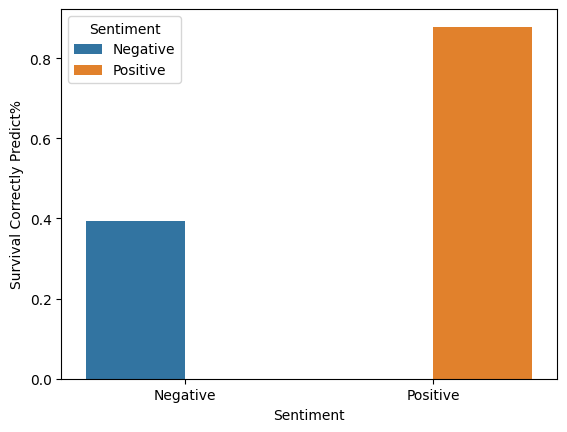

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(x = 'Sentiment', y = 'Ratio', hue = 'Sentiment', data = df_ratio).set(xlabel='Sentiment', ylabel='Survival Correctly Predict%')

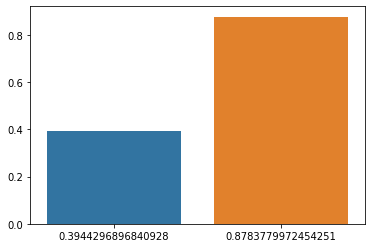

In [ ]:
# importing the required library
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


sns.barplot(x = 'Sentiment', y = 'survived', hue = 'class', data = titanic_dataset).set(xlabel='Gender', ylabel='Survival Rate')
 
# who v/s fare barplot
sns.barplot(x = [pos,neg],y = [pos,neg]).set(xlabel='Gender', ylabel='Survival Rate')
 
# Show the plot
plt.show()

In [ ]:
#len(df_senti_pd[(df_senti_pd['rating']== 4) & (df_senti_pd['sentiment']== "1.0")]) #57017
#len(df_senti_pd[(df_senti_pd['rating'] == 5) & (df_senti_pd['sentiment']== "1.0")]) #316710
#len(df_senti_pd[(df_senti_pd['sentiment']== "1.0")]) #425474 Pos
len(df_senti_pd[(df_senti_pd['sentiment']== "2.0")]) #57232 Neg

57232

In [ ]:
import pandas as pd
import plotly.express as px

pd.options.plotting.backend = "plotly"

ratings = pd.DataFrame(df_senti_pd.groupby('rating')['sentiment'].count())
#this shows that we have a higher number of 5.0 ratings
fig = df_senti_pd['rating'].plot.hist(title="Neg Reivews defined by TextBlob")
fig.update_layout(bargap=0.6)
fig.show()

In [ ]:
import pandas as pd
import plotly.express as px

pd.options.plotting.backend = "plotly"

ratings = pd.DataFrame(df_neg2_pd.groupby('rating')['sentiment'].count())
#this shows that we have a higher number of 5.0 ratings
fig = df_neg2_pd['rating'].plot.hist(title="Neg Reivews defined by TextBlob")
fig.update_layout(bargap=0.6)
fig.show()

In [ ]:
import pandas as pd
import plotly.express as px

pd.options.plotting.backend = "plotly"

ratings = pd.DataFrame(df_neg_pd.groupby('rating')['sentiment'].count())
#this shows that we have a higher number of 5.0 ratings
fig = df_neg_pd['rating'].plot.hist(title="Neg Reivews (rating == 1 and 2)")
fig.update_layout(bargap=0.6)
fig.show()

### 6 categories text analysis

In [ ]:
df_neg.show(5)
#df_neg.count() 

+------------+--------+--------------------+----------+---------------+------+----------+--------------------+---------+--------------------+------------------+
|SerialNumber|verified|            itemName|     brand|       category|rating|reviewTime|          reviewText|sentiment|            polarity|      subjectivity|
+------------+--------+--------------------+----------+---------------+------+----------+--------------------+---------+--------------------+------------------+
|           6|    true|Merrick Whole Ear...|   Merrick|   Pet_Supplies|     2|  1/1/2018|We accidentally p...|      2.0|              -0.125|             0.625|
|           9|    true|Penn Plax Net Bre...| Penn Plax|   Pet_Supplies|     2|  1/1/2018|Very flimsy and c...|      1.0| 0.22000000000000003|             0.425|
|          10|    true|PetSafe Freedom A...|   PetSafe|   Pet_Supplies|     1|  1/1/2018|Came with parts m...|      2.0|                -0.2|              0.05|
|          12|    true|Avery Remov

In [ ]:
from pyspark.sql.functions import sum, col, desc
df_categ= df_neg.select('category','brand','rating')\
  .groupBy("category")\
  .count()\
  .sort(desc('count'))

In [ ]:
df_categ.show(truncate=False)

+---------------------------+-----+
|category                   |count|
+---------------------------+-----+
|Pet_Supplies               |23749|
|Grocery_and_Gourmet_Food   |9226 |
|Patio_Lawn_and_Garden      |7473 |
|Cell_Phones_and_Accessories|5430 |
|Office_Products            |4501 |
|Arts_Crafts_and_Sewing     |2232 |
|Musical_Instruments        |1286 |
|Video_Games                |1226 |
|Prime_Pantry               |831  |
|Industrial_and_Scientific  |448  |
|Luxury_Beauty              |194  |
|All_Beauty                 |158  |
|Software                   |57   |
|AMAZON_FASHION             |38   |
|Digital_Music              |4    |
+---------------------------+-----+



In [ ]:
df_pet = df_neg.filter( (df_neg.category  == "Pet_Supplies"))
df_food = df_neg.filter( (df_neg.category  == "Grocery_and_Gourmet_Food"))
df_garden = df_neg.filter( (df_neg.category  == "Patio_Lawn_and_Garden"))
df_office = df_neg.filter( (df_neg.category  == "Office_Products"))
df_phones = df_neg.filter( (df_neg.category  == "Cell_Phones_and_Accessories"))
df_arts = df_neg.filter( (df_neg.category  == "Arts_Crafts_and_Sewing"))

In [ ]:
df_pet.show(5)

+------------+--------+--------------------+----------+------------+------+----------+--------------------+---------+--------------------+------------------+
|SerialNumber|verified|            itemName|     brand|    category|rating|reviewTime|          reviewText|sentiment|            polarity|      subjectivity|
+------------+--------+--------------------+----------+------------+------+----------+--------------------+---------+--------------------+------------------+
|           6|    true|Merrick Whole Ear...|   Merrick|Pet_Supplies|     2|  1/1/2018|We accidentally p...|      2.0|              -0.125|             0.625|
|           9|    true|Penn Plax Net Bre...| Penn Plax|Pet_Supplies|     2|  1/1/2018|Very flimsy and c...|      1.0| 0.22000000000000003|             0.425|
|          10|    true|PetSafe Freedom A...|   PetSafe|Pet_Supplies|     1|  1/1/2018|Came with parts m...|      2.0|                -0.2|              0.05|
|          14|   false|Tropiclean Oxymed...|TropiCle

## Data Overview

### Top categories/ brand


In [ ]:
from pyspark.sql.functions import sum, col, desc
df_brand= df1.select('brand','rating','reviewTime')\
  .groupBy("brand")\
  .count()\
  .sort(desc('count'))

In [ ]:
df_brand.show()

+--------------------+-----+
|               brand|count|
+--------------------+-----+
|                KONG| 6511|
|        AmazonBasics| 4238|
|                KIND| 3835|
|                 NaN| 3789|
|             PetSafe| 3250|
|            Nylabone| 3122|
|            OtterBox| 3040|
|              Kaytee| 2864|
|               Anker| 2722|
|                  HP| 2354|
|               Avery| 2273|
|             Sharpie| 2199|
|             Petmate| 2119|
|MidWest Homes for...| 2037|
|               Pilot| 1984|
|              Puppia| 1773|
|            Multipet| 1710|
|            Greenies| 1670|
|       Outward Hound| 1588|
|             Samsung| 1587|
+--------------------+-----+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import sum, col, desc
df_categ= df1.select('category','brand','rating','reviewTime')\
  .groupBy("category")\
  .count()\
  .sort(desc('count'))

In [ ]:
df_categ.show(truncate=False)

+---------------------------+------+
|category                   |count |
+---------------------------+------+
|Pet_Supplies               |188358|
|Grocery_and_Gourmet_Food   |98731 |
|Patio_Lawn_and_Garden      |63996 |
|Office_Products            |61889 |
|Cell_Phones_and_Accessories|41881 |
|Arts_Crafts_and_Sewing     |35040 |
|Musical_Instruments        |17510 |
|Prime_Pantry               |15387 |
|Video_Games                |12557 |
|Industrial_and_Scientific  |6110  |
|Luxury_Beauty              |2049  |
|All_Beauty                 |499   |
|AMAZON_FASHION             |490   |
|Software                   |257   |
|Appliances                 |209   |
|Digital_Music              |69    |
+---------------------------+------+



In [ ]:
df1.count()

545032

In [ ]:
df_brand_cate= df1.select('category','brand')\
  .groupBy('category','brand')\
  .count()\
  .sort(desc('count'))

In [ ]:
df_brand_cate.show(truncate=False)

+---------------------------+----------------------+-----+
|category                   |brand                 |count|
+---------------------------+----------------------+-----+
|Pet_Supplies               |KONG                  |6511 |
|Grocery_and_Gourmet_Food   |KIND                  |3736 |
|Pet_Supplies               |PetSafe               |3225 |
|Pet_Supplies               |Nylabone              |3122 |
|Cell_Phones_and_Accessories|OtterBox              |3040 |
|Cell_Phones_and_Accessories|Anker                 |2722 |
|Pet_Supplies               |Kaytee                |2675 |
|Office_Products            |HP                    |2347 |
|Office_Products            |Avery                 |2255 |
|Office_Products            |Sharpie               |2185 |
|Pet_Supplies               |Petmate               |2119 |
|Pet_Supplies               |AmazonBasics          |2081 |
|Luxury_Beauty              |NaN                   |2049 |
|Pet_Supplies               |MidWest Homes for Pets|2036

In [ ]:
#df.select('category').distinct().count() #2236
#df1.select('category').distinct().collect()

## TEXT Processing

### Basic preprocessing

In [ ]:
from sparknlp.base import *
from sparknlp.annotator import *
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

In [ ]:
from sparknlp.base import *

documentAssembler = DocumentAssembler()\
      .setInputCol("reviewText")\
      .setOutputCol("document")\
      .setCleanupMode("shrink")

In [ ]:
from sparknlp.annotator import *

# we feed the document column coming from Document Assembler

sentenceDetector = SentenceDetector()\
    .setInputCols(['document'])\
    .setOutputCol('sentences')

In [ ]:
df_text=df1.select('reviewText')

In [ ]:
doc_df = documentAssembler.transform(df_text)
token_df = tokenizer.fit(doc_df).transform(doc_df)
token_df.show(truncate=100)

+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                                          reviewText|                                                                                            document|                                                                                               token|
+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                            super smooth and yummy w

In [ ]:
token_df.select('token.result').take(1)

[Row(result=['super', 'smooth', 'and', 'yummy', 'with', 'crunchy', 'bits'])]

In [ ]:
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token") \
    .setSplitChars(['-']) \
    .setContextChars(['?', '!']) \
    .addException("New York") \

In [ ]:
token_df = tokenizer.fit(doc_df).transform(doc_df)

token_df.select('token.result').take(1)

[Row(result=['super', 'smooth', 'and', 'yummy', 'with', 'crunchy', 'bits'])]

### Text Normalizer

In [ ]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
from sparknlp.base import *
from sparknlp.annotator import *

documentAssembler = DocumentAssembler()\
    .setInputCol("reviewText")\
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")
    
normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized")\
    .setLowercase(True)\
    .setCleanupPatterns(["[^\w\d\s]"]) # remove punctuations (keep alphanumeric chars)
    # if we don't set CleanupPatterns, it will only keep alphabet letters ([^A-Za-z])

nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    tokenizer,
    normalizer
 ])


empty_df = spark.createDataFrame([['']]).toDF("reviewText")
pipelineModel = nlpPipeline.fit(empty_df)

In [ ]:
pipelineModel.stages

[DocumentAssembler_d77afce14f13,
 REGEX_TOKENIZER_3146b3fcd261,
 NORMALIZER_fdbd78a1b991]

In [ ]:
result = pipelineModel.transform(df1)

### Token Assembler

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("reviewText")\
    .setOutputCol("document")

sentenceDetector = SentenceDetector()\
    .setInputCols(['document'])\
    .setOutputCol('sentences')

tokenizer = Tokenizer() \
    .setInputCols(["sentences"]) \
    .setOutputCol("token")

normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized")\
    .setLowercase(False)\

stopwords_cleaner = StopWordsCleaner()\
    .setInputCols("normalized")\
    .setOutputCol("cleanTokens")\
    .setCaseSensitive(False)\

tokenassembler = TokenAssembler()\
    .setInputCols(["sentences", "cleanTokens"]) \
    .setOutputCol("clean_text")


nlpPipeline = Pipeline(stages=[
    documentAssembler,
    sentenceDetector,
    tokenizer,
    normalizer,
    stopwords_cleaner,
    tokenassembler
 ])


empty_df = spark.createDataFrame([['']]).toDF("reviewText")

pipelineModel = nlpPipeline.fit(empty_df)

result = pipelineModel.transform(df1)

result.show()

+------------+--------+--------------------+--------------------+--------------------+------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|SerialNumber|verified|            itemName|               brand|            category|rating|reviewTime|          reviewText|            document|           sentences|               token|          normalized|         cleanTokens|          clean_text|
+------------+--------+--------------------+--------------------+--------------------+------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|           1|    true|Toblerone Swiss M...|           Toblerone|        Prime_Pantry|     5|  1/1/2018|super smooth and ...|[{document, 0, 39...|[{document, 0, 39...|[{token, 0, 4, su...|[{token, 0, 4, su...|[{token, 0, 4, su...|[{document, 0,

In [ ]:
# if we use TokenAssembler().setPreservePosition(True), the original borders will be preserved (dropped & unwanted chars will be replaced by spaces)
#result.select('clean_text').take(1)

[Row(clean_text=[Row(annotatorType='document', begin=0, end=30, result='super smooth yummy crunchy bits', metadata={'sentence': '0'}, embeddings=[])])]

In [ ]:
import pyspark.sql.functions as F
#result.select('reviewText', F.explode('clean_text.result').alias('clean_text')).show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------+
|reviewText                                                            

In [ ]:
#result.select(F.explode('clean_text.result').alias('clean_text')).show(truncate=False)

+------------------------------------------------------------------------------------------------------------+
|clean_text                                                                                                  |
+------------------------------------------------------------------------------------------------------------+
|super smooth yummy crunchy bits                                                                             |
|Perfect kombucha                                                                                            |
|Finally harness fits puppy                                                                                  |
|really need harness fits pound pug Chihuahua mixshe odd shape chest pull harness going big head easy anymore|
|harness finally adjusted size perfectly without issue                                                       |
|Also light weight worried going cause issues big bulky                                                      |
|

In [ ]:
#result.select('reviewText', F.explode('clean_text.result').alias('clean_text')).toPandas()

#### important steps!

In [ ]:
#result.select('reviewText', F.explode('clean_text.result').alias('clean_text'))\
#  .groupBy('clean_text') \
#  .count() \
#  .sort('count', ascending=False) \
#  .show()

In [ ]:
#import pyspark.sql.functions as F

#result.withColumn(
#    "tmp", 
#    F.explode("clean_text")) \
#    .select("tmp.*").select("begin","end","result","metadata.sentence").show(truncate = False)

## Filter (negative & positive one)

negative reviews

In [ ]:
df_pet = result.filter( (result.category  == "Pet_Supplies") & (result.rating.isin([1.0, 2.0])))
df_food = result.filter( (result.category  == "Grocery_and_Gourmet_Food") & (result.rating.isin([1.0, 2.0])))
df_garden = result.filter( (result.category  == "Patio_Lawn_and_Garden") & (result.rating.isin([1.0, 2.0])))
df_office = result.filter( (result.category  == "Office_Products") & (result.rating.isin([1.0, 2.0])))
df_phones = result.filter( (result.category  == "Cell_Phones_and_Accessories")& (result.rating.isin([1.0, 2.0])))
df_arts = result.filter( (result.category  == "Arts_Crafts_and_Sewing") & (result.rating.isin([1.0, 2.0])))

positive reviews 

In [ ]:
df_pet_pos = result.filter( (result.category  == "Pet_Supplies") & (result.rating.isin([4.0, 5.0])))
df_food_pos = result.filter( (result.category  == "Grocery_and_Gourmet_Food") & (result.rating.isin([4.0, 5.0])))
df_garden_pos = result.filter( (result.category  == "Patio_Lawn_and_Garden") & (result.rating.isin([4.0, 5.0])))
df_office_pos = result.filter( (result.category  == "Office_Products") & (result.rating.isin([4.0, 5.0])))
df_phones_pos = result.filter( (result.category  == "Cell_Phones_and_Accessories")& (result.rating.isin([4.0, 5.0])))
df_arts_pos = result.filter( (result.category  == "Arts_Crafts_and_Sewing") & (result.rating.isin([4.0, 5.0])))

#### sentence freq

In [ ]:
df_pet.select('reviewText', F.explode('clean_text.result').alias('clean_text'))\
  .groupBy('clean_text') \
  .count() \
  .sort('count', ascending=False) \
  .show()

+--------------------+-----+
|          clean_text|count|
+--------------------+-----+
|                    | 6961|
|        disappointed|  232|
|         Waste money|  165|
|                 buy|  156|
|                work|  124|
|         waste money|  119|
|               small|  108|
|        Buyer beware|  101|
|           recommend|   95|
|            Returned|   93|
|    Dont waste money|   91|
|neighbor cats won...|   74|
|horrible product ...|   74|
|nothing like pict...|   74|
|cat wont touch ex...|   74|
|cat loves catnip ...|   74|
|cant return item ...|   74|
|              WARNED|   74|
|Im disappointed p...|   74|
|    therefore catnip|   74|
+--------------------+-----+
only showing top 20 rows



In [ ]:
df_food.select('reviewText', F.explode('clean_text.result').alias('clean_text'))\
  .groupBy('clean_text') \
  .count() \
  .sort('count', ascending=False) \
  .show()

+-------------+-----+
|   clean_text|count|
+-------------+-----+
|             | 3524|
| disappointed|  154|
|          buy|   98|
|         Yuck|   77|
|         good|   68|
|disappointing|   56|
|        sweet|   52|
|    recommend|   44|
|  Waste money|   42|
| Disappointed|   42|
|        stale|   31|
|     purchase|   31|
|       flavor|   30|
|     Wont buy|   30|
|        Stale|   29|
|         like|   28|
|  waste money|   27|
|Disappointing|   27|
|        Never|   26|
|          fan|   26|
+-------------+-----+
only showing top 20 rows



In [ ]:
df_garden.select('reviewText', F.explode('clean_text.result').alias('clean_text'))\
  .groupBy('clean_text') \
  .count() \
  .sort('count', ascending=False) \
  .show()

+----------------+-----+
|      clean_text|count|
+----------------+-----+
|                | 2521|
|    disappointed|   78|
|Dont waste money|   67|
|             buy|   57|
|            work|   48|
|     Waste money|   40|
|     waste money|   35|
|        Returned|   31|
|            Junk|   28|
|       recommend|   27|
|    Disappointed|   26|
|        returned|   26|
|      Didnt grow|   25|
|      Never grew|   24|
|         Garbage|   23|
|           happy|   22|
|      Didnt work|   20|
|            good|   19|
|         nothing|   18|
|     Doesnt work|   17|
+----------------+-----+
only showing top 20 rows



In [ ]:
df_office.select('reviewText', F.explode('clean_text.result').alias('clean_text'))\
  .groupBy('clean_text') \
  .count() \
  .sort('count', ascending=False) \
  .show()

+----------------+-----+
|      clean_text|count|
+----------------+-----+
|                | 1578|
|    disappointed|   62|
|             buy|   33|
|        returned|   27|
|     waste money|   27|
|       recommend|   23|
|        Returned|   23|
|           happy|   22|
|    Disappointed|   20|
|         get pay|   20|
|            work|   18|
|   disappointing|   17|
|    Poor quality|   16|
|        Horrible|   16|
|          return|   13|
|        purchase|   13|
|             BUY|   13|
|          flimsy|   12|
|Dont waste money|   11|
|            good|   11|
+----------------+-----+
only showing top 20 rows



In [ ]:
df_phones.select('reviewText', F.explode('clean_text.result').alias('clean_text'))\
  .groupBy('clean_text') \
  .count() \
  .sort('count', ascending=False) \
  .show()

+----------------+-----+
|      clean_text|count|
+----------------+-----+
|                | 1294|
|    disappointed|   59|
|             buy|   39|
|       recommend|   38|
|            good|   37|
|            work|   35|
|Dont waste money|   29|
|     waste money|   29|
|        Returned|   28|
|        returned|   24|
|     Waste money|   20|
|            Junk|   19|
|              ok|   18|
|             fit|   18|
|         Garbage|   16|
|    Disappointed|   16|
|          return|   16|
|           Cheap|   15|
|        Dont buy|   15|
|             bad|   14|
+----------------+-----+
only showing top 20 rows



In [ ]:
df_arts.select('reviewText', F.explode('clean_text.result').alias('clean_text'))\
  .groupBy('clean_text') \
  .count() \
  .sort('count', ascending=False) \
  .show()

+--------------------+-----+
|          clean_text|count|
+--------------------+-----+
|                    |  701|
|        disappointed|   50|
|               small|   21|
|        Disappointed|   17|
|                 buy|   17|
|    Dont waste money|   16|
|         Waste money|   15|
|            expected|   14|
|                good|   11|
|                 bad|   10|
|           described|   10|
|        Buyer beware|   10|
|           recommend|    9|
|               happy|    9|
|         bad product|    8|
|            Returned|    8|
|             get pay|    8|
|              ripoff|    8|
|thought larger si...|    7|
|     net torn easily|    7|
+--------------------+-----+
only showing top 20 rows



In [ ]:
df_pet_pos.select('reviewText', F.explode('clean_text.result').alias('clean_text'))\
  .groupBy('clean_text') \
  .count() \
  .sort('count', ascending=False) \
  .show()

+----------------+-----+
|      clean_text|count|
+----------------+-----+
|                |25012|
|       dog loves| 1450|
|       dogs love| 1251|
|            Love| 1201|
|            love| 1160|
|   Great product| 1158|
|     Works great|  888|
|       cats love|  784|
|           great|  698|
|Highly recommend|  607|
|           Thank|  599|
|           loves|  596|
|             buy|  572|
|            good|  565|
|       Dogs love|  523|
|           Great|  489|
|       cat loves|  482|
|         Perfect|  468|
|          Thanks|  428|
|     Great price|  422|
+----------------+-----+
only showing top 20 rows



In [ ]:
df_food_pos.select('reviewText', F.explode('clean_text.result').alias('clean_text'))\
  .groupBy('clean_text') \
  .count() \
  .sort('count', ascending=False) \
  .show()

+-------------+-----+
|   clean_text|count|
+-------------+-----+
|             |13813|
|         good| 1564|
|         Love| 1175|
|    Delicious|  964|
|         love|  861|
|          buy|  700|
|    delicious|  614|
|        great|  587|
|Great product|  585|
|        Great|  540|
|         Good|  527|
|          Yum|  463|
|        Yummy|  460|
|        tasty|  416|
|        Thank|  391|
|  Great taste|  332|
|    Excellent|  307|
|       Thanks|  307|
|        yummy|  297|
|     expected|  283|
+-------------+-----+
only showing top 20 rows



In [ ]:
df_garden_pos.select('reviewText', F.explode('clean_text.result').alias('clean_text'))\
  .groupBy('clean_text') \
  .count() \
  .sort('count', ascending=False) \
  .show()

+-------------+-----+
|   clean_text|count|
+-------------+-----+
|             |10302|
|  Works great|  641|
|         good|  444|
|         Love|  434|
|Great product|  397|
|        great|  356|
|         love|  334|
|  works great|  321|
|        Great|  275|
|   Works well|  269|
|        Thank|  242|
|     far good|  241|
|    described|  228|
|         nice|  226|
|          buy|  225|
|   advertised|  221|
|      Perfect|  221|
|       Thanks|  215|
| Good product|  205|
|           ok|  192|
+-------------+-----+
only showing top 20 rows



In [ ]:
df_office_pos.select('reviewText', F.explode('clean_text.result').alias('clean_text'))\
  .groupBy('clean_text') \
  .count() \
  .sort('count', ascending=False) \
  .show()

+-------------+-----+
|   clean_text|count|
+-------------+-----+
|             | 6201|
|         Love|  680|
|         good|  560|
|        great|  553|
|     expected|  518|
|Great product|  457|
|         love|  456|
|        Great|  440|
|  Works great|  404|
|        Thank|  397|
|      Perfect|  358|
|    described|  358|
|         Good|  347|
| Good product|  309|
|          buy|  309|
|       Thanks|  247|
|       needed|  227|
|   Works well|  222|
|    Excellent|  207|
|   advertised|  198|
+-------------+-----+
only showing top 20 rows



In [ ]:
df_phones_pos.select('reviewText', F.explode('clean_text.result').alias('clean_text'))\
  .groupBy('clean_text') \
  .count() \
  .sort('count', ascending=False) \
  .show()

+-------------+-----+
|   clean_text|count|
+-------------+-----+
|             | 3898|
|         Love|  460|
|         good|  448|
|  Works great|  442|
|         Good|  370|
|Great product|  347|
|         love|  304|
|        Great|  257|
|        great|  212|
|         nice|  188|
|    Excellent|  185|
|   Great case|  183|
|      Perfect|  177|
|        Thank|  175|
|           ok|  154|
|       Thanks|  151|
|  works great|  147|
|     far good|  145|
|   Works well|  139|
| Good product|  137|
+-------------+-----+
only showing top 20 rows



In [ ]:
df_arts_pos.select('reviewText', F.explode('clean_text.result').alias('clean_text'))\
  .groupBy('clean_text') \
  .count() \
  .sort('count', ascending=False) \
  .show()

+-------------+-----+
|   clean_text|count|
+-------------+-----+
|             | 3455|
|         Love|  604|
|         love|  450|
|        great|  340|
|        Thank|  273|
|Great product|  260|
|        Great|  248|
|  Works great|  245|
|     expected|  218|
|         nice|  210|
|      Perfect|  198|
|         good|  198|
|       Thanks|  173|
|    described|  169|
|          buy|  163|
|      perfect|  116|
|  works great|  113|
|       needed|  111|
|         Good|  110|
|great product|  107|
+-------------+-----+
only showing top 20 rows



## data transformation (NEG)

In [ ]:
df_pet_pd = df_pet.select(F.explode('clean_text.result').alias('clean_text')).toPandas()
df_food_pd = df_food.select(F.explode('clean_text.result').alias('clean_text')).toPandas()
df_garden_pd = df_garden.select(F.explode('clean_text.result').alias('clean_text')).toPandas()
df_office_pd = df_office.select(F.explode('clean_text.result').alias('clean_text')).toPandas()
df_phones_pd = df_phones.select(F.explode('clean_text.result').alias('clean_text')).toPandas()
df_arts_pd = df_arts.select(F.explode('clean_text.result').alias('clean_text')).toPandas()

In [ ]:
pet_list = df_pet_pd['clean_text'].tolist()
food_list = df_food_pd['clean_text'].tolist()
garden_list = df_garden_pd['clean_text'].tolist()
office_list = df_office_pd['clean_text'].tolist()
phones_list = df_phones_pd['clean_text'].tolist()
arts_list = df_arts_pd['clean_text'].tolist()

In [ ]:
from pyspark import SparkConf
from pyspark import SparkContext
#sparkDF=spark.createDataFrame(df_cate_pet_brand1_pd_review) 
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
r_pet = sc.parallelize(pet_list)
r_food = sc.parallelize(food_list)
r_garden = sc.parallelize(garden_list)
r_office = sc.parallelize(office_list)
r_phone = sc.parallelize(phones_list)
r_arts = sc.parallelize(arts_list)

In [ ]:
words_pet =r_pet.flatMap(lambda line: line.split(" "))
words_food =r_food.flatMap(lambda line: line.split(" "))
words_garden =r_garden.flatMap(lambda line: line.split(" "))
words_office =r_office.flatMap(lambda line: line.split(" "))
words_phone =r_phone.flatMap(lambda line: line.split(" "))
words_arts =r_arts.flatMap(lambda line: line.split(" "))

In [ ]:
wordCount_pet = words_pet.map(lambda word: (word, 1)).reduceByKey(lambda a,b:a +b)
wordCount_food = words_food.map(lambda word: (word, 1)).reduceByKey(lambda a,b:a +b)
wordCount_garden = words_garden.map(lambda word: (word, 1)).reduceByKey(lambda a,b:a +b)
wordCount_office = words_office.map(lambda word: (word, 1)).reduceByKey(lambda a,b:a +b)
wordCount_phone = words_phone.map(lambda word: (word, 1)).reduceByKey(lambda a,b:a +b)
wordCount_arts = words_arts.map(lambda word: (word, 1)).reduceByKey(lambda a,b:a +b)

In [ ]:
output_pet = wordCount_pet.collect()
output_food = wordCount_food.collect()
output_garden  = wordCount_garden.collect()
output_office = wordCount_office.collect()
output_phone = wordCount_phone.collect()
output_arts = wordCount_arts.collect()

In [ ]:
output_list_pet = wordCount_pet.map(lambda x: (x[1], x[0])).sortByKey(False).take(50)
output_list_food = wordCount_food.map(lambda x: (x[1], x[0])).sortByKey(False).take(50)
output_list_garden = wordCount_garden.map(lambda x: (x[1], x[0])).sortByKey(False).take(50)
output_list_office = wordCount_office.map(lambda x: (x[1], x[0])).sortByKey(False).take(50)
output_list_phone = wordCount_phone.map(lambda x: (x[1], x[0])).sortByKey(False).take(50)
output_list_arts = wordCount_arts.map(lambda x: (x[1], x[0])).sortByKey(False).take(50)

## data transformation (POS)

In [ ]:
df_pet_pos_pd = df_pet_pos.select(F.explode('clean_text.result').alias('clean_text')).toPandas()
df_food_pos_pd = df_food_pos.select(F.explode('clean_text.result').alias('clean_text')).toPandas()
df_garden_pos_pd = df_garden_pos.select(F.explode('clean_text.result').alias('clean_text')).toPandas()
df_office_pos_pd = df_office_pos.select(F.explode('clean_text.result').alias('clean_text')).toPandas()
df_phones_pos_pd = df_phones_pos.select(F.explode('clean_text.result').alias('clean_text')).toPandas()
df_arts_pos_pd = df_arts_pos.select(F.explode('clean_text.result').alias('clean_text')).toPandas()

In [ ]:
pet_pos_list = df_pet_pos_pd['clean_text'].tolist()
food_pos_list = df_food_pos_pd['clean_text'].tolist()
garden_pos_list = df_garden_pos_pd['clean_text'].tolist()
office_pos_list = df_office_pos_pd['clean_text'].tolist()
phones_pos_list = df_phones_pos_pd['clean_text'].tolist()
arts_pos_list = df_arts_pos_pd['clean_text'].tolist()

In [ ]:
from pyspark import SparkConf
from pyspark import SparkContext
#sparkDF=spark.createDataFrame(df_cate_pet_brand1_pd_review) 
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
r_pet_pos = sc.parallelize(pet_pos_list)
r_food_pos = sc.parallelize(food_pos_list)
r_garden_pos = sc.parallelize(garden_pos_list)
r_office_pos = sc.parallelize(office_pos_list)
r_phone_pos = sc.parallelize(phones_pos_list)
r_arts_pos = sc.parallelize(arts_pos_list)

In [ ]:
words_pet_pos =r_pet_pos.flatMap(lambda line: line.split(" "))
words_food_pos =r_food_pos.flatMap(lambda line: line.split(" "))
words_garden_pos =r_garden_pos.flatMap(lambda line: line.split(" "))
words_office_pos =r_office_pos.flatMap(lambda line: line.split(" "))
words_phone_pos =r_phone_pos.flatMap(lambda line: line.split(" "))
words_arts_pos =r_arts_pos.flatMap(lambda line: line.split(" "))

In [ ]:
wordCount_pet_pos = words_pet_pos.map(lambda word: (word, 1)).reduceByKey(lambda a,b:a +b)
wordCount_food_pos = words_food_pos.map(lambda word: (word, 1)).reduceByKey(lambda a,b:a +b)
wordCount_garden_pos = words_garden_pos.map(lambda word: (word, 1)).reduceByKey(lambda a,b:a +b)
wordCount_office_pos = words_office_pos.map(lambda word: (word, 1)).reduceByKey(lambda a,b:a +b)
wordCount_phone_pos = words_phone_pos.map(lambda word: (word, 1)).reduceByKey(lambda a,b:a +b)
wordCount_arts_pos = words_arts_pos.map(lambda word: (word, 1)).reduceByKey(lambda a,b:a +b)

In [ ]:
output_pet_pos = wordCount_pet_pos.collect()
output_food_pos = wordCount_food_pos.collect()
output_garden_pos  = wordCount_garden_pos.collect()
output_office_pos = wordCount_office_pos.collect()
output_phone_pos = wordCount_phone_pos.collect()
output_arts_pos = wordCount_arts_pos.collect()

In [ ]:
output_list_pet_pos = wordCount_pet_pos.map(lambda x: (x[1], x[0])).sortByKey(False).take(50)
output_list_food_pos = wordCount_food_pos.map(lambda x: (x[1], x[0])).sortByKey(False).take(50)
output_list_garden_pos = wordCount_garden_pos.map(lambda x: (x[1], x[0])).sortByKey(False).take(50)
output_list_office_pos = wordCount_office_pos.map(lambda x: (x[1], x[0])).sortByKey(False).take(50)
output_list_phone_pos = wordCount_phone_pos.map(lambda x: (x[1], x[0])).sortByKey(False).take(50)
output_list_arts_pos = wordCount_arts_pos.map(lambda x: (x[1], x[0])).sortByKey(False).take(50)

## word count (sorted_neg)

- transform into pandas dataframe

In [ ]:
# pet
import pandas as pd
output_df_pet = pd.DataFrame(output_list_pet, columns=['frequency', 'word'])
output_df_pet = output_df_pet[["word", "frequency"]]
output_df_pet.head(20)


In [ ]:
import pandas as pd
output_df_food = pd.DataFrame(output_list_food, columns=['frequency', 'word'])
output_df_food = output_df_food[["word", "frequency"]]
output_df_food.head(20)

,word,frequency
0,,3524
1,like,3309
2,taste,2731
3,flavor,1651
4,good,1367
5,product,1270
6,one,1126
7,coffee,1086
8,dont,906
9,tea,841


In [ ]:
import pandas as pd
output_df_garden = pd.DataFrame(output_list_garden, columns=['frequency', 'word'])
output_df_garden = output_df_garden[["word", "frequency"]]
output_df_garden.head(20)

,word,frequency
0,,2521
1,one,1664
2,work,991
3,use,984
4,like,966
5,get,934
6,product,835
7,water,792
8,time,765
9,dont,673


In [ ]:
import pandas as pd
output_df_office = pd.DataFrame(output_list_office, columns=['frequency', 'word'])
output_df_office = output_df_office[["word", "frequency"]]
output_df_office.head(20)

,word,frequency
0,,1578
1,one,921
2,printer,909
3,ink,903
4,use,788
5,work,735
6,paper,718
7,like,686
8,get,667
9,time,537


In [ ]:
import pandas as pd
output_df_phone = pd.DataFrame(output_list_phone, columns=['frequency', 'word'])
output_df_phone = output_df_phone[["word", "frequency"]]
output_df_phone.head(20)

,word,frequency
0,phone,2432
1,case,1736
2,,1294
3,one,1064
4,screen,945
5,work,696
6,like,686
7,use,653
8,charge,642
9,get,572


In [ ]:
import pandas as pd
output_df_arts = pd.DataFrame(output_list_arts, columns=['frequency', 'word'])
output_df_arts = output_df_arts[["word", "frequency"]]
output_df_arts.head(20)

,word,frequency
0,,701
1,use,443
2,like,396
3,one,387
4,get,302
5,work,281
6,yarn,264
7,dont,252
8,time,214
9,product,211


In [ ]:
pet_neg_top30 = output_df_pet.head(30)
food_neg_top30 = output_df_food.head(30)
garden_neg_top30 = output_df_garden.head(30)
office_neg_top30 = output_df_office.head(30)
phone_neg_top30 = output_df_phone.head(30)
arts_neg_top30 = output_df_arts.head(30)

## word count (sorted_pos)

- transform into pandas dataframe

In [ ]:
# pet
import pandas as pd
output_df_pet_pos = pd.DataFrame(output_list_pet_pos, columns=['frequency', 'word'])
output_df_pet_pos = output_df_pet_pos[["word", "frequency"]]
output_df_pet_pos.head(20)

,word,frequency
0,dog,36114
1,,25012
2,love,23975
3,one,23551
4,dogs,22100
5,like,21754
6,great,21246
7,loves,19339
8,cat,17693
9,well,16882


In [ ]:
import pandas as pd
output_df_food_pos = pd.DataFrame(output_list_food_pos, columns=['frequency', 'word'])
output_df_food_pos = output_df_food_pos[["word", "frequency"]]
output_df_food_pos.head(20)

,word,frequency
0,good,16666
1,,13813
2,like,12571
3,great,12365
4,taste,11164
5,flavor,10331
6,love,8709
7,coffee,8311
8,Great,8149
9,tea,7422


In [ ]:
import pandas as pd
output_df_garden_pos = pd.DataFrame(output_list_garden_pos, columns=['frequency', 'word'])
output_df_garden_pos = output_df_garden_pos[["word", "frequency"]]
output_df_garden_pos.head(20)

,word,frequency
0,,10302
1,great,9030
2,well,7578
3,good,6590
4,one,6486
5,use,6108
6,like,5299
7,product,4888
8,works,4640
9,Great,3920


In [ ]:
import pandas as pd
output_df_office_pos = pd.DataFrame(output_list_office_pos, columns=['frequency', 'word'])
output_df_office_pos = output_df_office_pos[["word", "frequency"]]
output_df_office_pos.head(20)

,word,frequency
0,great,8843
1,use,7042
2,good,6587
3,,6201
4,well,5768
5,Great,5433
6,like,5155
7,one,5104
8,paper,4853
9,price,4733


In [ ]:
import pandas as pd
output_df_phone_pos = pd.DataFrame(output_list_phone_pos, columns=['frequency', 'word'])
output_df_phone_pos = output_df_phone_pos[["word", "frequency"]]
output_df_phone_pos.head(20)

,word,frequency
0,phone,11865
1,case,10102
2,great,6334
3,one,4815
4,good,4781
5,well,4166
6,like,3991
7,,3898
8,screen,3459
9,product,3215


In [ ]:
import pandas as pd
output_df_arts_pos = pd.DataFrame(output_list_arts_pos, columns=['frequency', 'word'])
output_df_arts_pos = output_df_arts_pos[["word", "frequency"]]
output_df_arts_pos.head(20)

,word,frequency
0,great,4889
1,use,4437
2,,3455
3,love,3099
4,Great,2943
5,good,2790
6,well,2707
7,like,2668
8,product,2305
9,Love,2257


In [ ]:
pet_pos_top30 = output_df_pet_pos.head(30)
food_pos_top30 = output_df_food_pos.head(30)
garden_pos_top30 = output_df_garden_pos.head(30)
office_pos_top30 = output_df_office_pos.head(30)
phone_pos_top30 = output_df_phone_pos.head(30)
arts_pos_top30 = output_df_arts_pos.head(30)

## Words Plot in 6 categories 

In [ ]:
import plotly.express as px
df = output_df_pet.loc[(output_df_pet['frequency'] > 2000)] # & (output_df_pet['word'] != " ")]
fig = px.bar(df, x='word', y='frequency',color='frequency',
             labels={'frequency_x':'Words Freq'}, height=400,title="Word Count in Verified Buyers - Negative Reviews in Pet Category")
fig.show()

In [ ]:
import plotly.express as px
#df = output_df_food.loc[(output_df_food['frequency'] > 1000)]
fig = px.bar(output_df_food, x='word', y='frequency',color='frequency',
             labels={'frequency_x':'Words Freq'}, height=400,title="Word Count in Verified Buyers - Negative Reviews in Food Category")
fig.show()

In [ ]:
import plotly.express as px
#df = output_df_garden.loc[(output_df_garden['frequency'] > 500)]
fig = px.bar(output_df_garden, x='word', y='frequency',color='frequency',
             labels={'frequency_x':'Words Freq'}, height=400,title="Word Count in Verified Buyers - Negative Reviews in Garden Category")
fig.show()

In [ ]:
import plotly.express as px
#df = output_df_office.loc[(output_df_office['frequency'] > 2000)]
fig = px.bar(output_df_office, x='word', y='frequency',color='frequency',
             labels={'frequency_x':'Words Freq'}, height=400,title="Word Count in Verified Buyers - Negative Reviews in Office Supplies Category")
fig.show()

In [ ]:
import plotly.express as px
df = output_df_phone.loc[(output_df_phone['frequency'] > 300)]
fig = px.bar(df, x='word', y='frequency',color='frequency',
             labels={'frequency_x':'Words Freq'}, height=400,title="Word Count in Verified Buyers - Negative Reviews in Phone Category")
fig.show()

In [ ]:
import plotly.express as px
#df = output_df_arts.loc[(output_df_arts['frequency'] > 2000)]
fig = px.bar(output_df_arts, x='word', y='frequency',color='frequency',
             labels={'frequency_x':'Words Freq'}, height=400,title="Word Count in Verified Buyers - Negative Reviews in Arts Category")
fig.show()

Remove duplicate words function

In [ ]:
import pandas as pd

def anti_join(x, y, on):
    """Return rows in x which are not present in y"""
    ans = pd.merge(left=x, right=y, how='left', indicator=True, on=on)
    ans = ans.loc[ans._merge == 'left_only', :].drop(columns= ['_merge','frequency_y'])
    return ans

def inner_join(x, y, on):
    """Return rows in x which are not present in y"""
    ans = pd.merge(left=x, right=y, how='inner', indicator=True, on=on)
    ans = ans.drop(columns='_merge')
    return ans

## 6 main Category Results


In [ ]:
pet_result = anti_join(pet_neg_top30, pet_pos_top30, "word" )
pet_result

,word,frequency_x
11,work,2382
12,even,2365
15,didnt,2177
18,Im,1800
19,back,1699
20,eat,1685
24,got,1623
25,money,1619
26,buy,1594
27,made,1586


In [ ]:
food_result = anti_join(food_neg_top30, food_pos_top30, "word" )
food_result

,word,frequency_x
8,dont,906
15,even,692
16,bad,671
17,tried,661
19,bag,628
20,didnt,619
22,tastes,585
25,tasted,559
26,box,548
27,sweet,508


In [ ]:
garden_result = anti_join(garden_neg_top30, garden_pos_top30, "word" )
garden_result

,word,frequency_x
10,even,614
11,money,610
12,back,602
13,two,593
18,seeds,534
19,buy,522
20,Im,495
21,didnt,494
25,got,459
26,plastic,451


In [ ]:
office_result = anti_join(office_neg_top30, office_pos_top30, "word" )
office_result

,word,frequency_x
11,even,460
14,Im,438
19,buy,399
20,print,397
21,back,396
23,cartridges,353
25,bought,349
26,HP,325
28,Ive,310
29,two,295


In [ ]:
phone_result = anti_join(phone_neg_top30, phone_pos_top30, "word" )
phone_result

,word,frequency_x
11,back,494
15,doesnt,455
17,months,423
20,even,404
21,battery,404
22,didnt,399
23,dont,369
24,got,367
25,broke,357
26,Im,356


In [ ]:
arts_result = anti_join(arts_neg_top30, arts_pos_top30, "word" )
arts_result

,word,frequency_x
6,yarn,264
7,dont,252
12,even,202
14,small,199
17,machine,188
18,Im,187
19,cut,180
20,money,174
21,buy,174
22,disappointed,172


## Remove duplicate words

In [ ]:
import pandas as pd

def anti_join(x, y, on):
    """Return rows in x which are not present in y"""
    ans = pd.merge(left=x, right=y, how='left', indicator=True, on=on)
    ans = ans.loc[ans._merge == 'left_only', :].drop(columns= ['_merge','frequency_y'])
    return ans

def inner_join(x, y, on):
    """Return rows in x which are not present in y"""
    ans = pd.merge(left=x, right=y, how='inner', indicator=True, on=on)
    ans = ans.drop(columns='_merge')
    return ans

### Pos and Neg reviews in Pet categories 

In [ ]:
df_pet_onlyN = anti_join(output_df_pet, output_df_pet_pos, "word" )
#df_pet_onlyN 
df_pet_both = inner_join(output_df_pet, output_df_pet_pos, "word" )
#df_pet_both

In [ ]:
df_pet_both['word'].replace('', np.nan, inplace=True)

In [ ]:
df_pet_both.dropna(subset=['word'], inplace=True)
df_pet_both.head(5)

,word,frequency_x,frequency_y
0,dog,6971,36114
2,like,4723,21754
3,one,4485,23551
4,dogs,3449,22100
5,cat,2958,17693


In [ ]:
df_pet_onlyN.head(5)

,word,frequency_x
11,work,2382
15,didnt,2177
19,back,1699
20,eat,1685
25,money,1619


In [ ]:
import plotly.express as px
# df = df_pet_onlyN.loc[(df_pet_onlyN['frequency_x']>=100) & (df['Age']< 60) & (df['FT_Team'].str.startswith('S')),['Name','FT_Team']]
#df = df_pet_onlyN.loc[(df_pet_onlyN['frequency_x'] > 350)] # with condition
fig = px.bar(df_pet_onlyN, x='word', y='frequency_x',color='frequency_x', 
             labels={'frequency_x':'Words Freq'}, width=600, height=400,title="Word Count in Negative Reviews - Pets Category")
fig.show()

In [ ]:
import plotly.express as px
fig = px.bar(df_pet_both, x='word', y='frequency_x',color='frequency_x',
             labels={'frequency_x':'Words Freq'}, width=600,height=400, title="Common Word Count in Both P and N Reviews - Pets Category")
fig.show()

### Pos and Neg reviews in Food categories 

In [ ]:
df_food_onlyN = anti_join(output_df_food, output_df_food_pos, "word" )
df_food_both = inner_join(output_df_food, output_df_food_pos, "word" )

In [ ]:
import plotly.express as px
# df = df_pet_onlyN.loc[(df_pet_onlyN['frequency_x']>=100) & (df['Age']< 60) & (df['FT_Team'].str.startswith('S')),['Name','FT_Team']]
#df = df_food_onlyN.loc[(df_food_onlyN['frequency_x'] > 350)] # with condition
fig = px.bar(df_food_onlyN, x='word', y='frequency_x',color='frequency_x', 
             labels={'frequency_x':'Words Freq'}, width=1000, height=400,title="Word Count in Negative Reviews - Food Category")
fig.show()

In [ ]:
import plotly.express as px
fig = px.bar(df_food_both, x='word', y='frequency_x',color='frequency_x',
             labels={'frequency_x':'Words Freq'}, width=1000, height=400, title="Common Word Count in Both P and N Reviews - Food Category")
fig.show()

### Pos and Neg reviews in Garden categories 

In [ ]:
df_garden_onlyN = anti_join(output_df_garden, output_df_garden_pos, "word" )
df_garden_both = inner_join(output_df_garden, output_df_garden_pos, "word" )

In [ ]:
import plotly.express as px
# df = df_pet_onlyN.loc[(df_pet_onlyN['frequency_x']>=100) & (df['Age']< 60) & (df['FT_Team'].str.startswith('S')),['Name','FT_Team']]
#df = df_garden_onlyN.loc[(df_garden_onlyN['frequency_x'] > 50)] # with condition
fig = px.bar(df_garden_onlyN, x='word', y='frequency_x',color='frequency_x', 
             labels={'frequency_x':'Words Freq'}, width=1000, height=400,title="Word Count in Negative Reviews - Garden Category")
fig.show()

In [ ]:
import plotly.express as px
fig = px.bar(df_garden_both, x='word', y='frequency_x',color='frequency_x',
             labels={'frequency_x':'Words Freq'},width=1000, height=400, title="Common Word Count in Both P and N Reviews - Garden Category")
fig.show()

### Pos and Neg reviews in Office categories 

In [ ]:
df_office_onlyN = anti_join(output_df_office, output_df_office_pos, "word" )
df_office_both = inner_join(output_df_office, output_df_office_pos, "word" )

In [ ]:
import plotly.express as px
# df = df_pet_onlyN.loc[(df_pet_onlyN['frequency_x']>=100) & (df['Age']< 60) & (df['FT_Team'].str.startswith('S')),['Name','FT_Team']]
#df = df_office_onlyN.loc[(df_office_onlyN['frequency_x'] > 100)] # with condition
fig = px.bar(df_office_onlyN, x='word', y='frequency_x',color='frequency_x', 
             labels={'frequency_x':'Words Freq'}, width=1000,height=400,title="Word Count in Negative Reviews - Office Supply Category")
fig.show()

In [ ]:
import plotly.express as px
fig = px.bar(df_office_both, x='word', y='frequency_x',color='frequency_x',
             labels={'frequency_x':'Words Freq'},width=1000, height=400, title="Common Word Count in Both P and N Reviews - Office Supply Category")
fig.show()

### Pos and Neg reviews in Cellphone categories 

In [ ]:
df_phone_onlyN = anti_join(output_df_phone, output_df_phone_pos, "word" )
df_phone_onlyN = inner_join(output_df_phone, output_df_phone_pos, "word" )

In [ ]:
import plotly.express as px
# df = df_pet_onlyN.loc[(df_pet_onlyN['frequency_x']>=100) & (df['Age']< 60) & (df['FT_Team'].str.startswith('S')),['Name','FT_Team']]
#df = df_phone_onlyN.loc[(df_phone_onlyN['frequency_x'] > 350)] # with condition
fig = px.bar(df_phone_onlyN, x='word', y='frequency_x',color='frequency_x', 
             labels={'frequency_x':'Words Freq'}, width=1000, height=400,title="Word Count in Negative Reviews - Cellphone Category")
fig.show()

In [ ]:
import plotly.express as px
fig = px.bar(df_phone_onlyN, x='word', y='frequency_x',color='frequency_x',
             labels={'frequency_x':'Words Freq'}, width=1000,height=400, title="Common Word Count in Both P and N Reviews - Cellphone Category")
fig.show()

### Pos and Neg reviews in arts categories 

In [ ]:
df_arts_onlyN = anti_join(output_df_arts, output_df_arts_pos, "word" )
df_arts_both = inner_join(output_df_arts, output_df_arts_pos, "word" )

In [ ]:
import plotly.express as px
# df = df_pet_onlyN.loc[(df_pet_onlyN['frequency_x']>=100) & (df['Age']< 60) & (df['FT_Team'].str.startswith('S')),['Name','FT_Team']]
#df = df_arts_onlyN.loc[(df_arts_onlyN['frequency_x'] > 100)] # with condition
fig = px.bar(df_arts_onlyN, x='word', y='frequency_x',color='frequency_x', 
             labels={'frequency_x':'Words Freq'},width=1000, height=400,title="Word Count in Negative Reviews - Arts Category")
fig.show()

In [ ]:
import plotly.express as px
fig = px.bar(df_arts_both, x='word', y='frequency_x',color='frequency_x',
             labels={'frequency_x':'Words Freq'}, width=1000, height=400, title="Common Word Count in Both P and N Reviews - Arts Category")
fig.show()